# Example ? Electron Cooling

In this example, we will show how to use the electron cooling module, found in [*darkhistory.elec.elec_cooling*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/darkhistory.electrons.elec_cooling.html). This module takes an injected electron with some initial energy, and cools it completely through inverse Compton scattering (ICS) as well as ionization, excitation (both on HI, HeI and HeII) as well as Coulomb heating from free electrons. 

## Initialization

Let's load the stuff that we need. The function of interest is [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html).

We have also imported the default binning for photons and electrons used throughout DarkHistory using [*config.load_data*](https://darkhistory.readthedocs.io/en/master/_autosummary/config/config.load_data.html).


In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

In [3]:
%matplotlib inline

In [8]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np

from config import load_data
import darkhistory.physics as phys
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf

photeng = load_data('binning')['phot']
eleceng = load_data('binning')['elec']

## Electron Cooling Function: [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html)

The user should refer to the online documentation for details on how to use [*get_elec_cooling_tf*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/electrons/elec_cooling/darkhistory.electrons.elec_cooling.get_elec_cooling_tf.html). In the simplest default case, we just need to give the function the electron and photon abscissae of interest, the redshift, and the ionization levels of hydrogen and helium.

If we do not specify any ICS transfer functions to the function, DarkHistory automatically loads the required transfer functions from the downloaded data. If this is the first time the transfer functions are loaded, the successful completion of the import would look like this:

```
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
```

In [11]:
rs = 600
# This function returns the baseline value of xHII. 
xHII  = phys.xHII_std(rs)

elec_cooling_info = get_elec_cooling_tf(
    eleceng, photeng, rs, xHII, check_conservation_eng=True, verbose=False
)


The output, stored in *elec_cooling_info*, is a tuple containing the following, as well as what each variable is indexed by: 

0. The secondary propagating photon transfer function $\overline{T}_\gamma$ (*eleceng*, *photeng*); 
1. The low-energy electron transfer function $\overline{T}_e$ (*eleceng*, *eleceng*); 
2. The energy deposited into ionization $\overline{R}_\text{ion}$ (*eleceng*); 
3. The energy deposited into excitation $\overline{R}_\text{exc}$ (*eleceng*);
4. The energy deposited into heating $\overline{R}_\text{heat}$ (*eleceng*); 
5. The total energy of upscattered CMB photons $\overline{R}_\text{CMB}$ (*eleceng*), and
6. Numerical error away from energy conservation (*eleceng*).

These transfer functions are functions of the injected electron energy, and tell us how energy is deposited by a *single* electron with that energy.

Let's make some plots to understand this. First, let's extract the high-energy deposition into ionization, excitation and heating. 

## High-Energy Deposition Fractions

In [12]:
elec_dep_ion  = elec_cooling_info[2]
elec_dep_exc  = elec_cooling_info[3]
elec_dep_heat = elec_cooling_info[4]

We'll make a plot of the fraction of energy deposited into each of these channels, as a function of the energy injected. These high-energy deposition fractions (for electrons above 3 keV) do *not* include the energy in low-energy electrons, which are processed separately in DarkHistory by [`physics.low_energy`](https://hongwanliu.github.io/DarkHistory/html/_autosummary/darkhistory/darkhistory.low_energy.html). 

[3200.0, 5000000000000.0, 1e-10, 1]

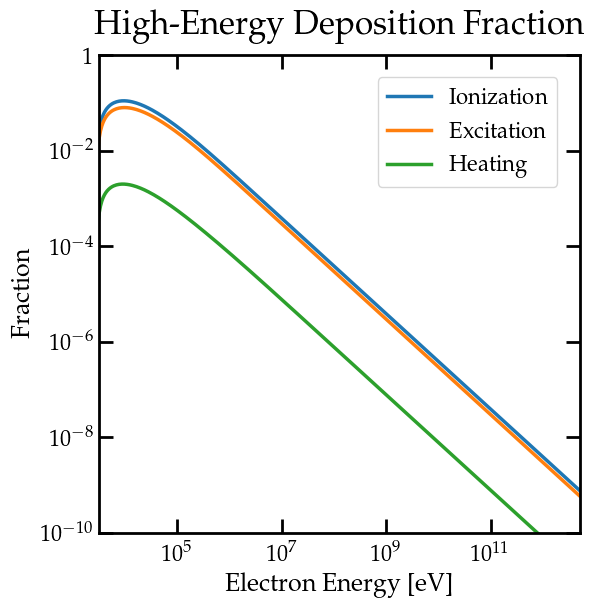

In [13]:
plt.figure()

plt.loglog()

ion_plot,  = plt.plot(eleceng, elec_dep_ion/eleceng,  label='Ionization')
exc_plot,  = plt.plot(eleceng, elec_dep_exc/eleceng,  label='Excitation')
heat_plot, = plt.plot(eleceng, elec_dep_heat/eleceng, label='Heating')

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Fraction')
plt.title('High-Energy Deposition Fraction')

plt.legend(handles=[ion_plot, exc_plot, heat_plot])

plt.axis([3.2e3, 5e12, 1e-10, 1])

This plot reflects the fact that for higher energy electrons, atomic processes become less important as channels of energy deposition: instead, most of the energy is instead transferred to CMB photons that undergo inverse Compton scattering (ICS). 

## Comparing Inverse Compton Scattering and Atomic Processes

Let's explicitly compare the energy deposited into inverse Compton scattering against the energy deposited via atomic processes plus the low-energy electrons. We will ultimately reproduce the plot shown as Fig. 2 of [arXiv:1506.03812](https://arxiv.org/abs/1506.03812). 

Let's add up all the energy in atomic processes plus low-energy electrons. First, we get the low-energy electrons, which is saved as a [*TransFuncAtRedshift*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/transferfunction/darkhistory.spec.transferfunction.TransFuncAtRedshift.html). We can obtain the total energy for each injected electron using `TransFuncAtRedshift.toteng()`. The function `toteng()` sums over the the last axis, i.e. it sums the energy of all photons in each spectrum corresponding to an injected electron. This can then be added to the other components to get the total energy deposited as atomic processes. 

In [14]:
lowengelec_tf = elec_cooling_info[1]

eng_dep_lowengelec = lowengelec_tf.toteng()

eng_dep_atomic = eng_dep_lowengelec + elec_dep_ion + elec_dep_exc + elec_dep_heat

Now let's look at the energy deposited into ICS. This is equal to the energy stored in the secondary propagating photon spectrum, minus the initial energy of these upscattered photons. Again, we can use `TransFuncAtRedshift.toteng()` to get the total energy in the photon spectrum, and then simply subtract the upscattered photon initial energy.

In [15]:
ICS_phot_tf = elec_cooling_info[0]

eng_dep_ICS_phot = ICS_phot_tf.toteng()

eng_initial_cmb = elec_cooling_info[5]

eng_dep_ICS = eng_dep_ICS_phot - eng_initial_cmb

All right, let's make the plot!

[1, 5000000000000.0, 0, 1.1]

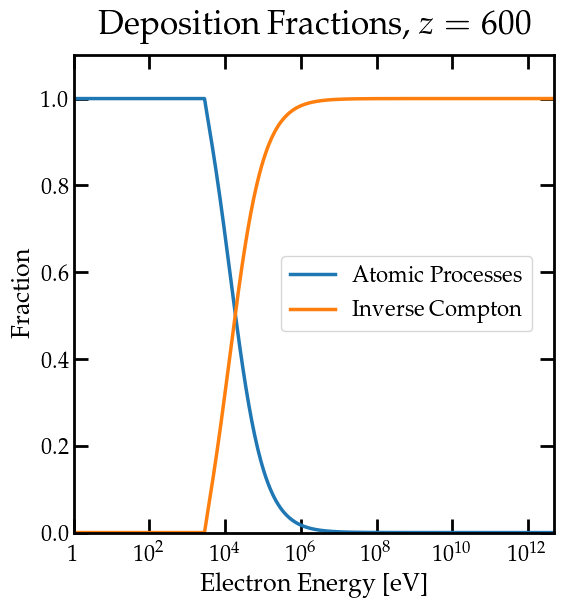

In [16]:
plt.figure()

ax = plt.gca()
ax.set_xscale('log')

atomic_plot, = plt.plot(eleceng, eng_dep_atomic/eleceng,  label='Atomic Processes')
ICS_plot,    = plt.plot(eleceng, eng_dep_ICS/eleceng,  label='Inverse Compton')

plt.xlabel('Electron Energy [eV]')
plt.ylabel('Fraction')
plt.title(r'Deposition Fractions, $z=600$')

plt.legend(handles=[atomic_plot, ICS_plot])

plt.axis([1, 5e12, 0, 1.1])

## Getting Spectra

The transfer function stored in `ICS_phot_tf` is essentially a list of photon spectra produced by a single electron at some injected energy. Acting this function by matrix multiplication on any arbitrary injection electron spectrum therefore gives the secondary photon spectrum produced after complete cooling of that spectrum. 

Let's take some electron spectrum, produced by annihilation of dark matter into a $\tau^+ \tau^-$ pair. This can be obtained from the [*darkhistory.spec.pppc*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/darkhistory.spec.pppc.html), which returns the same flux produced by PPPC4DMID <cite data-cite="6232408/W944VR5Z"></cite>. We'll pick $m_\text{DM}$ = 50 GeV, and obtain the spectrum per annihilation.

In [19]:
from darkhistory.spec.pppc import get_pppc_spec

mDM = 50e9

elec_spec = get_pppc_spec(mDM, eleceng, 'tau', 'elec')

`elec_spec` here is a [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object, and contains the abscissa (`eleceng`) and the spectrum, stored as dN/dE or N. To contract this spectrum with `ICS_phot_tf`, we use the `TransferFuncAtRedshift.sum_specs`, which acts the matrix stored in `ICS_phot_tf` on the spectrum. 

In [20]:
phot_spec = ICS_phot_tf.sum_specs(elec_spec.N)

This produces a photon [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object, with the abscissa given by `photeng`. 

We can also produce the initial spectrum of photons that got scattered. This is a blackbody spectrum, since we are only tracking photons that get upscattered in the nonrelativistic, Thomson regime (see the paper for more details). The CMB spectrum at any temperature can be obtained using [*physics.CMB_spec*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/physics/darkhistory.physics.CMB_spec.html). This returns a spectrum containing $dN/(dE\, dV)$ of the CMB. We simply have to rescale this spectrum to the correct initial energy, and this information is stored in `eng_initial_cmb`. 

First, let's put the spectrum in a [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object.  

In [21]:
from darkhistory.spec.spectrum import Spectrum

# Use physics.TCMB() to get the temperature at the right redshift.
CMB_spec = Spectrum(photeng, phys.CMB_spec(photeng, phys.TCMB(rs)), spec_type='dNdE')


Now, we want to rescale this spectrum so that it has the energy of the photons that got upscattered. This energy is given by `np.dot(eng_initial_cmb, elec_spec.N)`, since `eng_initial_cmb` has each bin normalized to one injected electron at some energy. 

We can do the rescaling simply by multiplying the [*Spectrum*](https://darkhistory.readthedocs.io/en/master/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object itself. 

In [22]:
CMB_spec *= np.dot(eng_initial_cmb, elec_spec.N)/CMB_spec.toteng()


Here are the produced spectra. and then rescale the total energy in that spectrum to `eng_initial_cmb` dotted into the electron spectrum: this is the initial CMB photon spectrum that got upscattered and are now stored in `phot_spec`.

[0.0001, 1000000000000.0, 1e-10, 1e+23]

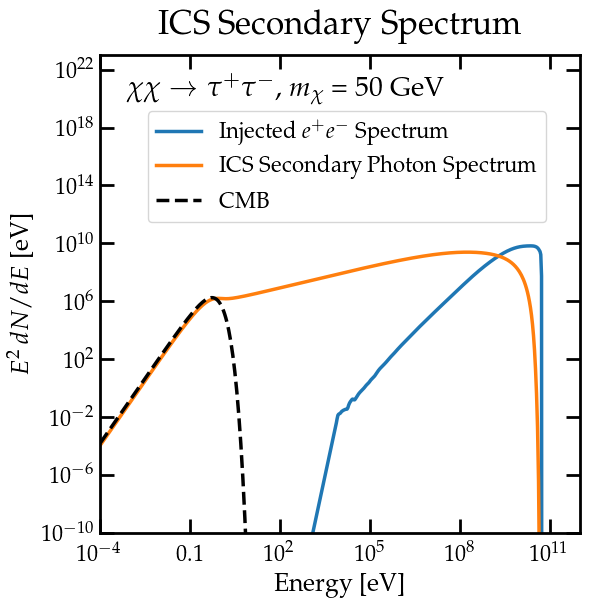

In [23]:
plt.figure()

plt.loglog()

elec_spec_plot, = plt.plot(eleceng, elec_spec.dNdE*eleceng**2, label=r'Injected $e^+e^-$ Spectrum')
phot_spec_plot, = plt.plot(photeng, phot_spec.dNdE*photeng**2, label='ICS Secondary Photon Spectrum')
CMB_plot,       = plt.plot(photeng, CMB_spec.dNdE*photeng**2,  'k--', label='CMB')

plt.xlabel('Energy [eV]')
plt.ylabel(r'$E^2\, dN/dE$ [eV]')
plt.title('ICS Secondary Spectrum')

plt.text(0.1, 0.92, r'$\chi \chi \to \tau^+\tau^-$, $m_\chi$ = 50 GeV', fontsize=20, transform=ax.transAxes) 

plt.legend(handles=[elec_spec_plot, phot_spec_plot, CMB_plot], loc=(0.1, 0.65))

plt.axis([1e-4, 1e12, 1e-10, 1e23])


The black dashed line shows the spectrum of photons that got upscattered as the electron spectrum (blue) cools completely, producing the final photon spectrum shown in orange. 

## Bibliography

<div class="cite2c-biblio"></div>